<a href="https://colab.research.google.com/github/thijsgelton/P10-G7_GANs/blob/main/P10_G7_GANs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

```
SOW-MKI95 Computer Graphics & Computer Vision
Generative adversarial networks
```

```
Group number: 7
Student 1 name/number: Marit Hagens, s4808061
Student 2 name/number: Joost Verhaert, s1047220
Student 3 name/number: Thijs Gelton, s4480783
```

In this lab, you will reimplement the DCGAN from the Gluon tutorial, convert it to a WGAN and compare their results after training them on different datasets.

#1. Install MXnet GPU and import libraries

In [ ]:
from mxnet import nd, gluon, util
from mxnet import autograd as ag
from mxnet.gluon import nn, utils

import matplotlib.pyplot as plt
import mxnet as mx
import numpy as np
import math
import os
import tarfile
from tqdm.notebook import tqdm
import seaborn as sns
from zipfile import ZipFile

%matplotlib inline

# Feel free to import other modules/packages

## 1.1 Set device context to gpu.

In [ ]:
def gpu_device(gpu_number=0):
    try:
        _ = mx.nd.array([1, 2, 3], ctx=mx.gpu(gpu_number))
    except mx.MXNetError:
        return None
    return mx.gpu(gpu_number)

gpu = gpu_device()

if gpu:
    print('Using GPU for model_ctx')
    ctx = gpu
else:
    print('Using CPU for model_ctx')
    ctx = mx.cpu()

Using GPU for model_ctx


### Task 1 (33 points):

Reimplement the DCGAN from the Gluon tutorial in this notebook. You can find the Gluon tutorial [here](https://gluon.mxnet.io/chapter14_generative-adversarial-networks/dcgan.html).

### Set hyperparameters

In [ ]:
epochs = 30 # Set low by default for tests, set higher when you actually run this code.
batch_size = 64
latent_z_size = 100
lr = 0.0002
beta1 = 0.5

### Download and preprocess the LWF Face Dataset

In [ ]:
lfw_url = 'http://vis-www.cs.umass.edu/lfw/lfw-deepfunneled.tgz'
data_path = 'lfw_dataset'
if not os.path.exists(data_path):
    os.makedirs(data_path)
    data_file = utils.download(lfw_url)
    with tarfile.open(data_file) as tar:
        tar.extractall(path=data_path)

Download the pokemon dataset via [this link](https://drive.google.com/drive/folders/1tO48PdTgdGeR4yYcm44OQkmme-MgT-jL?usp=sharing) and save it to your personal Google Drive. 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [ ]:

class CustomNormalise(nn.HybridBlock):
    def __init__(self):
        super(CustomNormalise, self).__init__()

    def hybrid_forward(self, F, x, *args):
        print(x, *args)
        return x / 127.5 - 1

class Ensure3D(nn.HybridBlock):
    def __init__(self):
        super(Ensure3D, self).__init__()

    def hybrid_forward(self, F, x, *args):
        print(x[0].asnumpy().shape, *args)
        if x.asnumpy().shape[0] == 1:
            x = nd.tile(x, (3, 1, 1))
        return x.reshape((1,) + x.shape)
    


In [ ]:
mx.gluon.data.vision.transforms.Resize(64)(img).shape

(64, 64, 3)

In [ ]:
target_wd = 64
target_ht = 64
img_list = []

def transform(data, lbl):
    # resize to target_wd * target_ht
    data = mx.image.imresize(data, target_wd, target_ht)
    # transpose from (target_wd, target_ht, 3)
    # to (3, target_wd, target_ht)
    data = nd.transpose(data, (2,0,1))
    # normalize to [-1, 1]
    data = data.astype(np.float32)/127.5 - 1
    # if image is greyscale, repeat 3 times to get RGB image.
    if data.shape[0] == 1:
        data = nd.tile(data, (3, 1, 1))
    return data



In [ ]:
for path, _, fnames in os.walk(data_path):
    for fname in fnames:
        if not fname.endswith('.jpg'):
            continue
        img = os.path.join(path, fname)
        img = mx.image.imread(img)
        img_arr = transform(img, target_wd, target_ht)
        img_list.append(img_arr)
        
train_data = mx.gluon.data.DataLoader(nd.concatenate(img_list), batch_size=batch_size, shuffle=True)

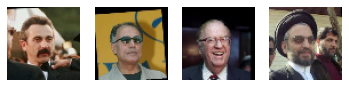

In [ ]:
def visualize(img_arr):
    plt.imshow(((img_arr.asnumpy().transpose(1, 2, 0) + 1.0) * 127.5).astype(np.uint8))
    plt.axis('off')

for i in range(4):
    plt.subplot(1,4,i+1)
    visualize(img_list[i + 10][0])
plt.show()

## Define the network


In [ ]:
class Discriminator(nn.Sequential):

    def __init__(self, ndf = 64, *args, **kwargs):
        super(Discriminator, self).__init__(*args, **kwargs)
        self.ndf = ndf
        with self.name_scope():    
            # input is (nc) x 64 x 64
            self.add(nn.Conv2D(self.ndf, 4, 2, 1, use_bias=False))
            self.add(nn.LeakyReLU(0.2))
            # state size. (ndf) x 32 x 32
            self.add(nn.Conv2D(self.ndf * 2, 4, 2, 1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.LeakyReLU(0.2))
            # state size. (ndf) x 16 x 16
            self.add(nn.Conv2D(self.ndf * 4, 4, 2, 1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.LeakyReLU(0.2))
            # state size. (ndf) x 8 x 8
            self.add(nn.Conv2D(self.ndf * 8, 4, 2, 1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.LeakyReLU(0.2))
            # state size. (ndf) x 4 x 4
            self.add(nn.Conv2D(1, 4, 1, 0, use_bias=False))

class Generator(nn.Sequential):

    def __init__(self, nc = 3, ngf = 64, *args, **kwargs):
        super(Generator, self).__init__(*args, **kwargs)
        self.nc = nc
        self.ngf = ngf
        with self.name_scope():    
            # input is Z, going into a convolution
            self.add(nn.Conv2DTranspose(self.ngf * 8, 4, 1, 0, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))
            # state size. (ngf*8) x 4 x 4
            self.add(nn.Conv2DTranspose(self.ngf * 4, 4, 2, 1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))
            # state size. (ngf*8) x 8 x 8
            self.add(nn.Conv2DTranspose(self.ngf * 2, 4, 2, 1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))
            # state size. (ngf*8) x 16 x 16
            self.add(nn.Conv2DTranspose(self.ngf, 4, 2, 1, use_bias=False))
            self.add(nn.BatchNorm())
            self.add(nn.Activation('relu'))
            # state size. (ngf*8) x 32 x 32
            self.add(nn.Conv2DTranspose(self.nc, 4, 2, 1, use_bias=False))
            self.add(nn.Activation('tanh'))

## Setup Loss Function and Optimizer

In [ ]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

In [ ]:
from datetime import datetime
import time
import logging

def facc(label, pred):
    pred = pred.ravel()
    label = label.ravel()
    return ((pred > 0.5) == label).mean()

metric = mx.metric.CustomMetric(facc)

def train_dcgan(dataset, net_g, net_d, trainer_g, trainer_d, metric, n_epochs, batch_size, latent_z_size):    
    real_label = nd.ones((batch_size,), ctx=ctx)
    fake_label = nd.zeros((batch_size,),ctx=ctx)
    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
    logging.basicConfig(level=logging.DEBUG)

    for epoch in range(n_epochs):
        tic = time.time()
        btic = time.time()
        iter = 0
        for data in dataset:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = data.as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

            with ag.record():
                # train with real image
                output = net_d(data).reshape((-1, 1))
                errD_real = loss(output, real_label)
                metric.update([real_label,], [output,])

                # train with fake image
                fake = net_g(latent_z)
                output = net_d(fake.detach()).reshape((-1, 1))
                errD_fake = loss(output, fake_label)
                errD = errD_real + errD_fake
                errD.backward()
                metric.update([fake_label,], [output,])

            trainer_d.step(data.shape[0])

            ############################
            # (2) Update G network: maximize log(D(G(z)))
            ###########################
            with ag.record():
                fake = net_g(latent_z)
                output = net_d(fake).reshape((-1, 1))
                errG = loss(output, real_label)
                errG.backward()

            trainer_g.step(data.shape[0])
            iter = iter + 1
            btic = time.time()

        name, acc = metric.get()
        metric.reset()
        logging.info('\nbinary training acc at epoch %d: %s=%f' % (epoch, name, acc))
        logging.info('time: %f' % (time.time() - tic))

        # Visualize one generated image for each epoch
        fake_img = fake[0]
        visualize(fake_img)
        plt.show()

INFO:root:
binary training acc at epoch 0: facc=0.836353
INFO:root:time: 15.212923


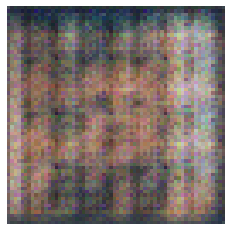

INFO:root:
binary training acc at epoch 1: facc=0.849713
INFO:root:time: 15.018980


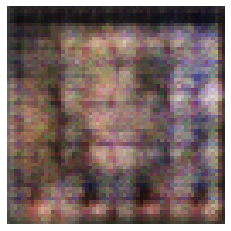

INFO:root:
binary training acc at epoch 2: facc=0.839976
INFO:root:time: 15.196917


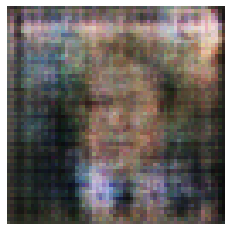

INFO:root:
binary training acc at epoch 3: facc=0.869339
INFO:root:time: 15.303204


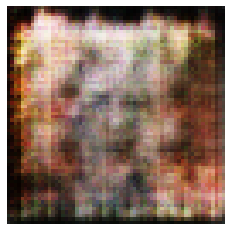

INFO:root:
binary training acc at epoch 4: facc=0.867376
INFO:root:time: 15.431097


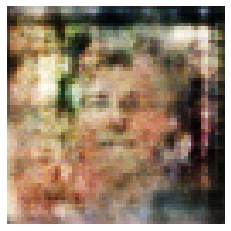

INFO:root:
binary training acc at epoch 5: facc=0.895079
INFO:root:time: 15.605343


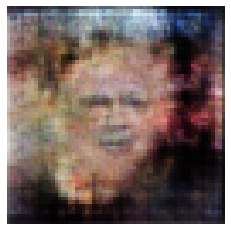

INFO:root:
binary training acc at epoch 6: facc=0.912138
INFO:root:time: 15.676932


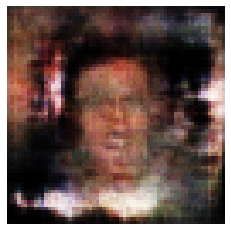

INFO:root:
binary training acc at epoch 7: facc=0.920479
INFO:root:time: 15.795156


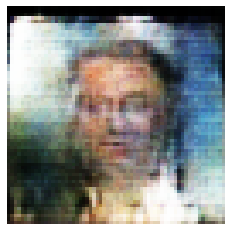

INFO:root:
binary training acc at epoch 8: facc=0.872698
INFO:root:time: 15.786453


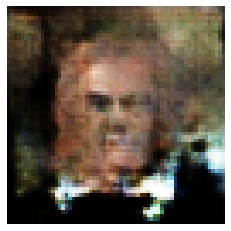

INFO:root:
binary training acc at epoch 9: facc=0.885002
INFO:root:time: 15.966662


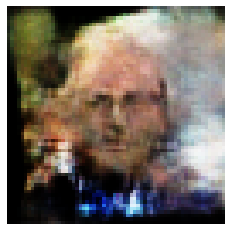

INFO:root:
binary training acc at epoch 10: facc=0.881756
INFO:root:time: 16.008710


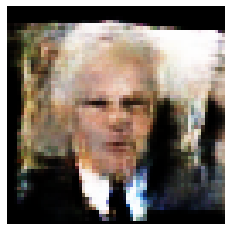

INFO:root:
binary training acc at epoch 11: facc=0.897947
INFO:root:time: 16.095964


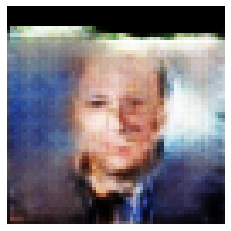

INFO:root:
binary training acc at epoch 12: facc=0.885719
INFO:root:time: 16.109563


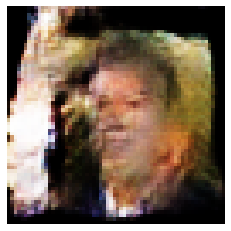

INFO:root:
binary training acc at epoch 13: facc=0.875226
INFO:root:time: 16.133616


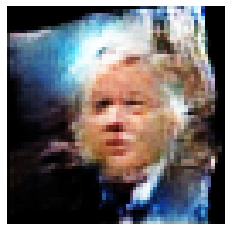

INFO:root:
binary training acc at epoch 14: facc=0.875830
INFO:root:time: 16.119711


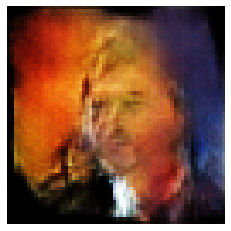

INFO:root:
binary training acc at epoch 15: facc=0.869565
INFO:root:time: 16.145736


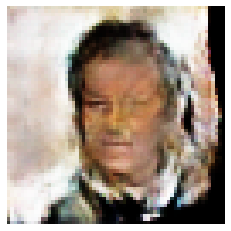

INFO:root:
binary training acc at epoch 16: facc=0.868244
INFO:root:time: 16.136481


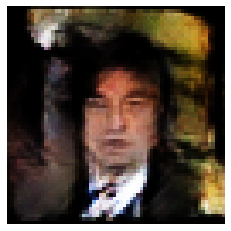

INFO:root:
binary training acc at epoch 17: facc=0.880322
INFO:root:time: 16.078046


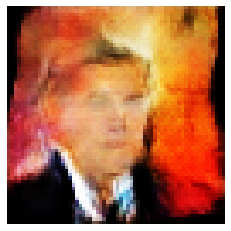

INFO:root:
binary training acc at epoch 18: facc=0.883756
INFO:root:time: 16.169659


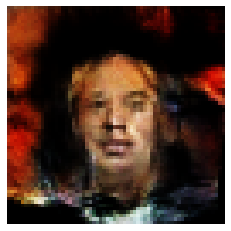

INFO:root:
binary training acc at epoch 19: facc=0.889757
INFO:root:time: 16.089787


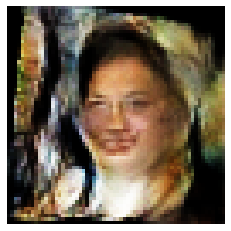

In [ ]:
train_dcgan(dataset=train_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=20, batch_size=batch_size, latent_z_size=latent_z_size)

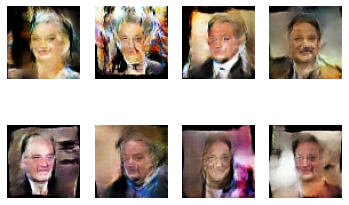

In [ ]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

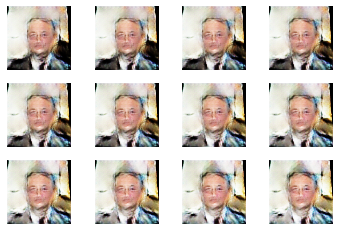

In [ ]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()

### Task 2 (33 points):

Convert the DCGAN to a WGAN.

You can refer to [the WGAN paper](https://arxiv.org/abs/1701.07875) and/or the below notes.

The paper introduces a new loss function for both the discriminator and the generator. Using this loss function instead of binary cross entropy results in a more stable convergence of the GAN.

#### Loss

Let’s compare the binary cross-entropy loss function (the function that that we are currently using to train the discriminator and generator of the DCGAN) to the Wasserstein loss function.

First, the Wasserstein loss requires that we use yi=1 and yi=-1 as labels, rather than 1 and 0. We also remove the sigmoid activation from the final layer of the discriminator, so that predictions pi are no longer constrained to fall in the range [0,1], but instead can now be any number in the range [–∞, ∞]. For this reason, the discriminator in a WGAN is usually referred to as a critic. The Wasserstein loss function is then defined as follows:

$$-\frac{1}{n} \sum_{i=1}^{n}\left(y_{i} p_{i}\right)$$

To train the WGAN critic D, we calculate the loss when comparing predictions for a real images pi=D(xi) to the response yi=1 and predictions for generated images pi=D(G(zi)) to the response yi=-1. Therefore for the WGAN critic, minimizing the loss function can be written as follows:

$$\min _{D}-\left(\mathbb{E}_{x \sim p_{X}}[D(x)]-\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

In other words, the WGAN critic tries to maximise the difference between its predictions for real images and generated images, with real images scoring higher. To train the WGAN generator, we calculate the loss when comparing predictions for generated images pi=D(G(zi)) to the response yi=1. Therefore for the WGAN generator, minimizing the loss function can be written as follows:

$$\min _{G}-\left(\mathbb{E}_{z \sim p_{Z}}[D(G(z))]\right)$$

#### Constraints

For the Wasserstein loss function to work, we also need to place an additional constraint on the critic. Specifically, it is required that the critic is a 1-Lipschitz continuous function. Let’s pick this apart to understand what it means in more detail. The critic is a function D that converts an image into a prediction. We say that this function is 1-Lipschitz if it satisfies the following inequality for any two input images, \( x_1 \) and \( x_2 \):

$$ \vert\frac{D(x_1)-D(x_2)\vert}{\vert x_1-x_2\vert}\leq1 $$

Essentially, we require a limit on the rate at which the predictions of the critic can change between two images (i.e., the absolute value of the gradient must be at most 1 everywhere).

It is possible to enforce the Lipschitz constraint by clipping the weights of the critic to lie within a small range, [–0.01, 0.01], after each training batch.

#### Training

When using the Wasserstein loss function, we should train the critic to convergence to ensure that the gradients for the generator update are accurate. This is in contrast to a standard GAN, where it is important not to let the discriminator get too strong, to avoid vanishing gradients.

Therefore, using the Wasserstein loss removes one of the key difficulties of training GANs—how to balance the training of the discriminator and generator. With WGANs, we can simply train the critic several times between generator updates, to ensure it is close to convergence. A typical ratio used is five critic updates to one generator update.

## Define the network


## Setup Loss Function and Optimizer

In [ ]:
# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# Clip initial weights
netD.forward(mx.nd.ones(shape=(batch_size, nc, 64, 64), ctx=ctx))
weights = netD.collect_params()
for i in weights:
    w = weights[i].data()
    mx.nd.clip(w, -0.01, 0.01, out=w)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'rmsprop', {'learning_rate': 0.00005})
trainerD = gluon.Trainer(netD.collect_params(), 'rmsprop', {'learning_rate': 0.00005})

NameError: name 'nc' is not defined

In [ ]:
from datetime import datetime
import time
import logging

metric = mx.metric.CustomMetric(facc)

def train_wgan(dataset, net_g, net_d, trainer_g, trainer_d, metric, n_epochs, batch_size, latent_z_size, n_critic=5):   
    real_label = nd.ones((batch_size,), ctx=ctx)
    fake_label = -nd.ones((batch_size,),ctx=ctx)
    stamp =  datetime.now().strftime('%Y_%m_%d-%H_%M')
    logging.basicConfig(level=logging.DEBUG)

    for epoch in range(n_epochs):
        tic = time.time()
        btic = time.time()
        iter = 0
        d_loss_epoch = []
        g_loss_epoch = []

        for data in dataset:
            ############################
            # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
            ###########################
            data = data.as_in_context(ctx)
            latent_z = mx.nd.random_normal(0, 1, shape=(batch_size, latent_z_size, 1, 1), ctx=ctx)

            for _ in range(n_critic):
                with ag.record():
                    # train with real image
                    output = net_d(data).reshape((-1, 1))
                    metric.update([real_label,], [output,])
                    d_loss_real = output

                    # train with fake image
                    fake = net_g(latent_z).detach()
                    output = net_d(fake).reshape((-1, 1))
                    metric.update([fake_label,], [output,])
                    d_loss_fake = output

                    d_loss = -(d_loss_real - d_loss_fake)
                    d_loss.backward()
                    d_loss_epoch.append(d_loss.detach().asnumpy()[0] / n_critic)
            
            trainer_d.step(data.shape[0])
            weights = net_d.collect_params()
            for x in weights:
                w = weights[x].data()
                nd.clip(w, -0.01, 0.01, out=w)
            
            with ag.record():
                fake = net_g(latent_z)
                output = net_d(fake).reshape((-1, 1))
                g_loss = -output
                g_loss.backward()
                g_loss_epoch.append(g_loss.detach().asnumpy()[0])

            trainer_g.step(data.shape[0])

            iter = iter + 1
            btic = time.time()

        acc = metric.get()
        metric.reset()
        print(f"D loss: {np.array(d_loss_epoch).mean()}\nG loss: {np.array(g_loss_epoch).mean()}\nAcc: {acc}")

        # Visualize one generated image for each epoch
        fake_img = fake[0]
        visualize(fake_img)
        plt.show()

D loss: -0.08520274609327316
G loss: 0.21043650805950165
Acc: ('facc', 0.010416666666666666)


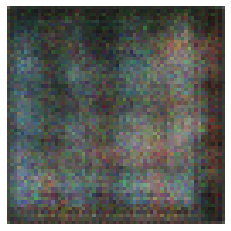

D loss: -0.12107419967651367
G loss: 0.3711443245410919
Acc: ('facc', 0.035703502415458936)


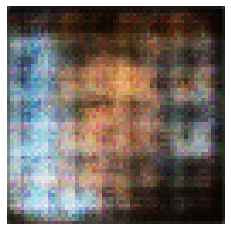

D loss: -0.1123877540230751
G loss: 0.36816173791885376
Acc: ('facc', 0.04596920289855073)


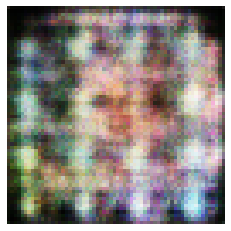

D loss: -0.10307716578245163
G loss: 0.37674540281295776
Acc: ('facc', 0.04910175120772947)


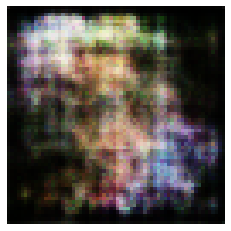

D loss: -0.09858644753694534
G loss: 0.3877805173397064
Acc: ('facc', 0.041553442028985504)


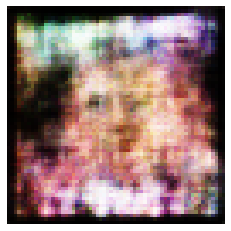

D loss: -0.09314165264368057
G loss: 0.3768472373485565
Acc: ('facc', 0.04079861111111111)


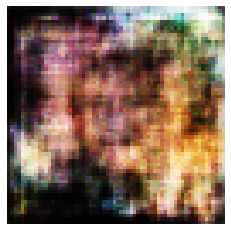

D loss: -0.09632940590381622
G loss: 0.3656764030456543
Acc: ('facc', 0.04008152173913043)


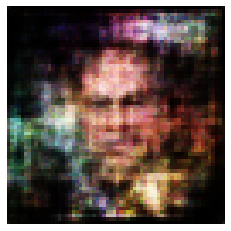

D loss: -0.10018784552812576
G loss: 0.35089969635009766
Acc: ('facc', 0.04132699275362319)


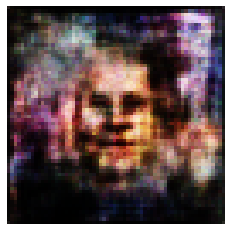

D loss: -0.07888920605182648
G loss: 0.2875296473503113
Acc: ('facc', 0.035363828502415456)


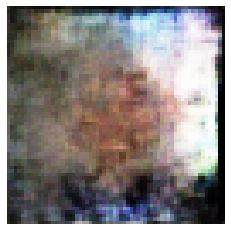

D loss: -0.07870680838823318
G loss: 0.28654810786247253
Acc: ('facc', 0.034118357487922704)


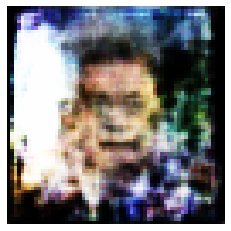

D loss: -0.08585840463638306
G loss: 0.30380597710609436
Acc: ('facc', 0.03777928743961353)


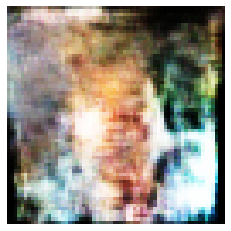

D loss: -0.08777547627687454
G loss: 0.30716803669929504
Acc: ('facc', 0.042232789855072464)


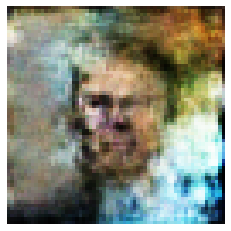

D loss: -0.094056636095047
G loss: 0.3154137432575226
Acc: ('facc', 0.04555404589371981)


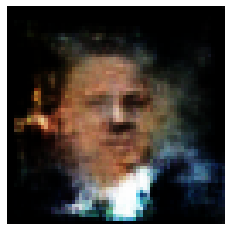

D loss: -0.09478062391281128
G loss: 0.3150554299354553
Acc: ('facc', 0.04830917874396135)


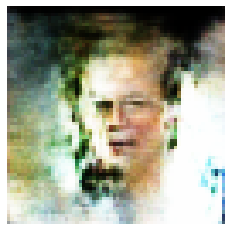

D loss: -0.09671787917613983
G loss: 0.31955575942993164
Acc: ('facc', 0.04751660628019324)


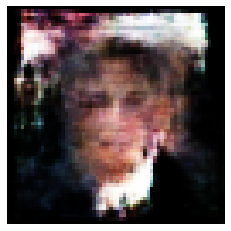

D loss: -0.09481348842382431
G loss: 0.3104793131351471
Acc: ('facc', 0.04729015700483092)


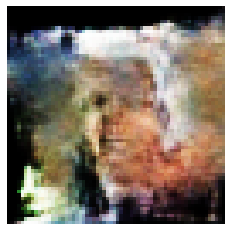

D loss: -0.09309138357639313
G loss: 0.29957348108291626
Acc: ('facc', 0.04502566425120773)


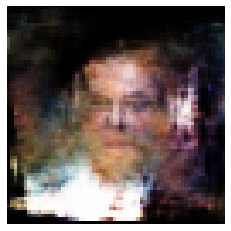

D loss: -0.09400947391986847
G loss: 0.31142133474349976
Acc: ('facc', 0.044270833333333336)


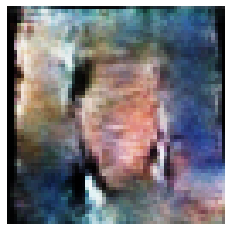

D loss: -0.09212245047092438
G loss: 0.29495781660079956
Acc: ('facc', 0.043817934782608696)


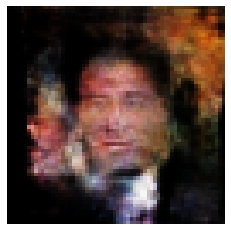

D loss: -0.09318279474973679
G loss: 0.30053192377090454
Acc: ('facc', 0.04132699275362319)


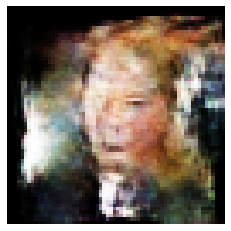

In [ ]:
train_wgan(dataset=train_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=20, batch_size=batch_size, latent_z_size=latent_z_size)

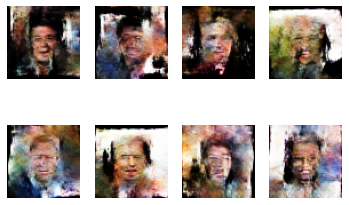

In [ ]:
num_image = 8
for i in range(num_image):
    latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
    img = netG(latent_z)
    plt.subplot(2,4,i+1)
    visualize(img[0])
plt.show()

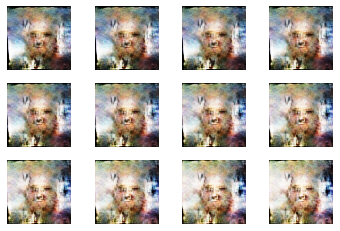

In [ ]:
num_image = 12
latent_z = mx.nd.random_normal(0, 1, shape=(1, latent_z_size, 1, 1), ctx=ctx)
step = 0.05
for i in range(num_image):
    img = netG(latent_z)
    plt.subplot(3,4,i+1)
    visualize(img[0])
    latent_z += 0.05
plt.show()

### Task 3 (33 points):

Compare their results of the DCGAN and the WGAN after training them on different datasets (at least three). You are free to select which datasets to use (it would be easier if you use relatively small datasets). For example, you can use MNIST and Fashion-MNIST datasets (available from Gluon) or anime characters and pokemons datasets (several versions can be found on GitHub).

In [ ]:
from mxnet.gluon.data.vision import datasets
from sklearn.model_selection import train_test_split
batch_size = 32

mnist = datasets.MNIST(train=True, transform=transform)
mnist_train_data = mx.gluon.data.DataLoader(mnist, batch_size, shuffle=True)

mnist_fashion = datasets.FashionMNIST(train=True, transform=transform)
mnist_fashion_train_data = mx.gluon.data.DataLoader(mnist_fashion, batch_size, shuffle=True)

pokemon_data = mx.gluon.data.DataLoader(datasets.ImageFolderDataset(root="D:\Google Drive\pokemon", transform=transform), batch_size, shuffle=True)

D:\Programs\Anaconda3\envs\mxnet\lib\site-packages\mxnet\gluon\data\vision\datasets.py:312: UserWarning: Ignoring D:\Google Drive\pokemon\images\desktop.ini of type .ini. Only support .jpg, .jpeg, .png
  filename, ext, ', '.join(self._exts)))


# First up the MNIST dataset

INFO:root:
binary training acc at epoch 0: facc=0.902933
INFO:root:time: 117.721799


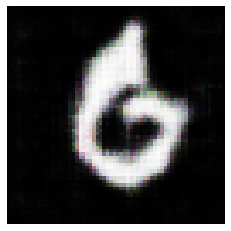

INFO:root:
binary training acc at epoch 1: facc=0.905825
INFO:root:time: 115.541975


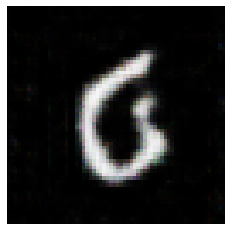

INFO:root:
binary training acc at epoch 2: facc=0.923250
INFO:root:time: 117.982473


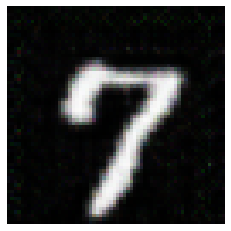

INFO:root:
binary training acc at epoch 3: facc=0.939833
INFO:root:time: 118.180483


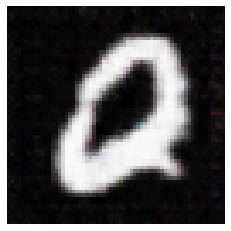

INFO:root:
binary training acc at epoch 4: facc=0.936467
INFO:root:time: 117.798141


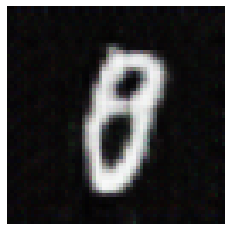

In [ ]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

metric = mx.metric.CustomMetric(facc)

train_dcgan(dataset=mnist_train_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=5, batch_size=batch_size, latent_z_size=latent_z_size)

D loss: -0.22398249804973602
G loss: 0.5971803665161133
Acc: ('facc', 0.33905833333333335)


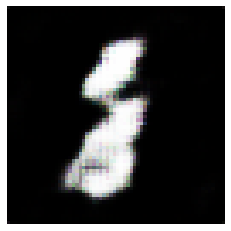

D loss: -0.14423330128192902
G loss: 0.43151170015335083
Acc: ('facc', 0.17244166666666666)


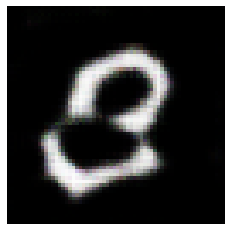

In [ ]:
# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# Clip initial weights
netD.forward(mx.nd.ones(shape=(batch_size, 3, 64, 64), ctx=ctx))
weights = netD.collect_params()
for i in weights:
    w = weights[i].data()
    mx.nd.clip(w, -0.01, 0.01, out=w)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'rmsprop', {'learning_rate': 0.00005})
trainerD = gluon.Trainer(netD.collect_params(), 'rmsprop', {'learning_rate': 0.00005})

metric = mx.metric.CustomMetric(facc)

train_wgan(dataset=mnist_train_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=20, batch_size=batch_size, latent_z_size=latent_z_size)

In [ ]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

metric = mx.metric.CustomMetric(facc)

train_dcgan(dataset=mnist_fashion_train_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=5, batch_size=batch_size, latent_z_size=latent_z_size)

In [ ]:
# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# Clip initial weights
netD.forward(mx.nd.ones(shape=(batch_size, nc, 64, 64), ctx=ctx))
weights = netD.collect_params()
for i in weights:
    w = weights[i].data()
    mx.nd.clip(w, -0.01, 0.01, out=w)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'rmsprop', {'learning_rate': 0.00005})
trainerD = gluon.Trainer(netD.collect_params(), 'rmsprop', {'learning_rate': 0.00005})

metric = mx.metric.CustomMetric(facc)

train_wgan(dataset=mnist_fashion_train_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=20, batch_size=batch_size, latent_z_size=latent_z_size)

In [ ]:
# loss
loss = gluon.loss.SigmoidBinaryCrossEntropyLoss()

# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})
trainerD = gluon.Trainer(netD.collect_params(), 'adam', {'learning_rate': lr, 'beta1': beta1})

metric = mx.metric.CustomMetric(facc)

train_dcgan(dataset=pokemon_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=5, batch_size=batch_size, latent_z_size=latent_z_size)

In [ ]:
# initialize the generator and the discriminator
netG = Generator()
netG.initialize(mx.init.Normal(0.02), ctx=ctx)
netD = Discriminator()
netD.initialize(mx.init.Normal(0.02), ctx=ctx)

# Clip initial weights
netD.forward(mx.nd.ones(shape=(batch_size, nc, 64, 64), ctx=ctx))
weights = netD.collect_params()
for i in weights:
    w = weights[i].data()
    mx.nd.clip(w, -0.01, 0.01, out=w)

# trainer for the generator and the discriminator
trainerG = gluon.Trainer(netG.collect_params(), 'rmsprop', {'learning_rate': 0.00005})
trainerD = gluon.Trainer(netD.collect_params(), 'rmsprop', {'learning_rate': 0.00005})

metric = mx.metric.CustomMetric(facc)

train_wgan(dataset=pokemon_data, net_g=netG, net_d=netD, trainer_g=trainerG, trainer_d=trainerD, metric=metric, n_epochs=20, batch_size=batch_size, latent_z_size=latent_z_size)